In [75]:
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import tensorflow as tf
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [76]:
cardiac_features = pd.read_csv('ECG_Cardiac_Features.csv')
cardiac_features.drop(columns=['Patient_ID'], inplace=True)
fourier_features = pd.read_csv('ECG_Fourier_Transform_Features.csv')
fourier_features.drop(columns=['Patient_ID', 'Label'], inplace=True)
time_features = pd.read_csv('ECG_Time_Features.csv')

merged_features = pd.merge(cardiac_features, fourier_features, on='ecg_id', how='inner')
merged_features = pd.merge(merged_features, time_features, on='ecg_id', how='inner')

merged_features.head()

,ecg_id,Label,Heart Rate,HRV_MeanNN,HRV_SDNN,HRV_RMSSD,HRV_pNN50,QRS_duration,PR_duration,RR Interval Mean,...,"value__agg_autocorrelation__f_agg_""median""__maxlag_40","value__fft_coefficient__attr_""abs""__coeff_17","value__fft_coefficient__attr_""abs""__coeff_11",value__lempel_ziv_complexity__bins_10,value__partial_autocorrelation__lag_3,value__partial_autocorrelation__lag_4,"value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""min""","value__agg_linear_trend__attr_""stderr""__chunk_len_50__f_agg_""var""",value__skewness,value__fourier_entropy__bins_3
0,1,NORM,63.847119,940.000000,17.320508,22.627417,0.000000,141.714286,127.333333,940.000000,...,0.065170,9.043106,74.502545,0.0838,-1.512835,2.218194,0.000088,0.000030,2.905521,0.220352
1,2,NORM,47.838174,1258.285714,82.836615,54.546616,42.857143,174.285714,152.000000,1258.285714,...,0.574924,58.900234,24.919214,0.0786,-1.059925,11.497906,0.000202,0.000027,2.195819,0.079983
2,3,NORM,63.822587,940.444444,20.019435,17.606817,0.000000,130.750000,114.500000,940.444444,...,0.125145,6.973763,100.593283,0.0810,-1.793943,1.794352,0.000112,0.000049,2.827517,0.183378
3,4,NORM,75.152692,800.545455,45.511237,35.185224,9.090909,160.727273,110.000000,800.545455,...,0.169628,29.327653,40.714874,0.0904,-1.299110,3.141033,0.000451,0.000043,0.282202,0.125256
4,5,NORM,66.456900,905.200000,51.018080,57.271284,50.000000,NaN,122.000000,905.200000,...,0.151764,5.776241,79.793704,0.0842,-1.839826,1.745159,0.000152,0.000018,1.634762,0.190068


In [ ]:
print(merged_features.columns)
print(merged_features.shape)

In [ ]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

In [79]:
classes = list(merged_features['Label'].unique())

feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    merged_features[col] = merged_features.groupby('Label')[col].transform(
        lambda x: x.fillna(x.mean())
    )

In [ ]:
feature_columns = [col for col in merged_features.columns if col not in ['ecg_id', 'Label']]

for col in feature_columns:
    print(f"{col}: {merged_features[col].isna().sum()} missing values")

In [81]:
X = merged_features[feature_columns]
y = merged_features['Label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


Accuracy: 0.6158038147138964


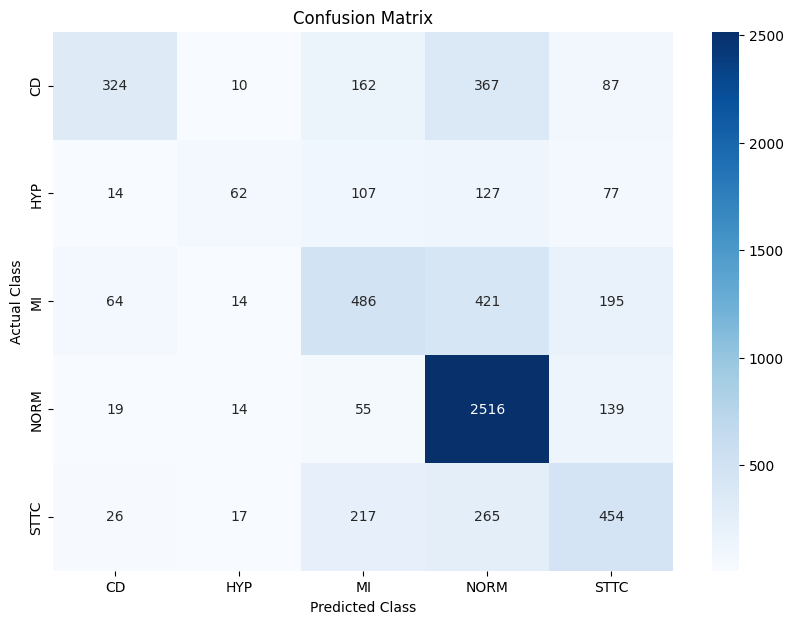

In [82]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy_rf)

conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
labels = sorted(set(y_test) | set(y_pred))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)

# Adding labels, title, and formatting
plt.xlabel("Predicted Class")
plt.ylabel("Actual Class")
plt.title("Confusion Matrix")
plt.show()

In [83]:
encoder = OneHotEncoder(sparse_output=False)
y_train_onehot = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_onehot = encoder.transform(y_test.values.reshape(-1, 1))

X_train_lstm = np.expand_dims(X_train, axis=1)  # Adding a timestep dimension
X_test_lstm = np.expand_dims(X_test, axis=1)

# Define the LSTM model
lstm_model = Sequential([
    Input(shape=(1, X_train.shape[1])),  # Define the input shape explicitly
    LSTM(256, return_sequences=True),
    Dropout(0.3),
    LSTM(128, return_sequences=True),
    Dropout(0.3),
    LSTM(64),
    Dropout(0.3),
    Dense(y_train_onehot.shape[1], activation='softmax')
])

lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

lstm_model.fit(X_train_lstm, y_train_onehot, epochs=25, batch_size=32, validation_data=(X_test_lstm, y_test_onehot))

lstm_loss, lstm_accuracy = lstm_model.evaluate(X_test_lstm, y_test_onehot, verbose=0)
print(f"LSTM Test Accuracy: {lstm_accuracy:.2f}")

Epoch 1/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.4322 - loss: 1.4528 - val_accuracy: 0.4397 - val_loss: 1.4275
Epoch 2/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4336 - loss: 1.4369 - val_accuracy: 0.4397 - val_loss: 1.4268
Epoch 3/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.4321 - loss: 1.4314 - val_accuracy: 0.4397 - val_loss: 1.4266
Epoch 4/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4391 - loss: 1.4282 - val_accuracy: 0.4397 - val_loss: 1.4264
Epoch 5/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4444 - loss: 1.4196 - val_accuracy: 0.4397 - val_loss: 1.4264
Epoch 6/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4306 - loss: 1.4322 - val_accuracy: 0.4397 - val_loss: 1.4264
Epoch 7/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4336 - loss: 1.4327 - val_accuracy: 0.4397 - val_loss: 1.4275
Epoch 8/25
455/455 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4434 - loss: 1.4215 - val_accuracy: 0.